# Cluster Analysis: Lexico-grammatical style (S. 5.2)

In [61]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier

from ruzicka.test_metrics import nini, minmax, cosine

In [15]:
%load_ext rpy2.ipython

In [71]:
ngram = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(9, 9),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
    # Never centre the data for use with minmax distance!
    StandardScaler(with_mean=False),
)

In [3]:
lenc = LabelEncoder()

In [4]:
vecs = pd.read_csv("elegy_corpus.csv", index_col=0)

In [5]:
vecs

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...


In [26]:
corpus = vecs[vecs.LEN >= 20]
corpus

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...


In [86]:
from sklearn.decomposition import TruncatedSVD

vectorizer = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True, use_idf=False, norm="l2", analyzer="char", ngram_range=(2, 4)
    ),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    StandardScaler(),
    TruncatedSVD(50, random_state=42),
    Normalizer(),
)

In [89]:
X = pd.DataFrame(vectorizer.fit_transform(corpus.Chunk))
y = list(corpus.Poem)

/Users/ben/venv/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/ben/venv/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [88]:
X.shape[1]

5000

In [97]:
dfs = []
rng = np.random.RandomState(seed=42)
for _ in range(500):
    # Sample 15 random features (columns)
    this_X = X.sample(int(X.shape[1] * 0.3), axis=1, random_state=rng)

    # Calculate kNN in that space
    cl = KNeighborsClassifier(n_neighbors=3, metric="cosine")
    cl.fit(this_X, y)
    dists, indices = cl.kneighbors(n_neighbors=3)

    # And build a dataframe from the results
    dicts = []
    for i, node_ary in enumerate(indices):
        for j, node in enumerate(node_ary):
            dicts.append(
                {
                    "from": y[i],
                    "to": y[node],
                    # neighbors are sorted low distance to high
                    # so this gives us the 'inverse rank' ie lowest
                    # distance of n neighbors scores n, next is n-1 etc
                    # this is consistent with the stylo BCT algorithm
                    "weight": (len(node_ary) - j),
                }
            )
    dfs.append(pd.DataFrame(dicts))

# Now aggregate the dataframes, summing the weights for
# identical (directed) edges
graph = pd.concat(dfs).groupby(["from", "to"], as_index=False).agg(sum)
graph_trim = graph.nlargest(int(len(graph) * 0.2), "weight")

In [98]:
graph_trim[graph_trim["from"].str.startswith("Consol")].head(10)

,from,to,weight
7257,Consolatio 1,Consolatio 2,323
7428,Consolatio 2,Consolatio 1,284
7607,Consolatio 3,Ep. 15,274
7564,Consolatio 2,Tr. 4 2,228
7258,Consolatio 1,Consolatio 3,218
7261,Consolatio 1,Ep. 11,214
7608,Consolatio 3,Ep. 16,214
7601,Consolatio 3,Consolatio 1,184
7412,Consolatio 2,Am. 2 4,178
7741,Consolatio 3,Tr. 4 2,178


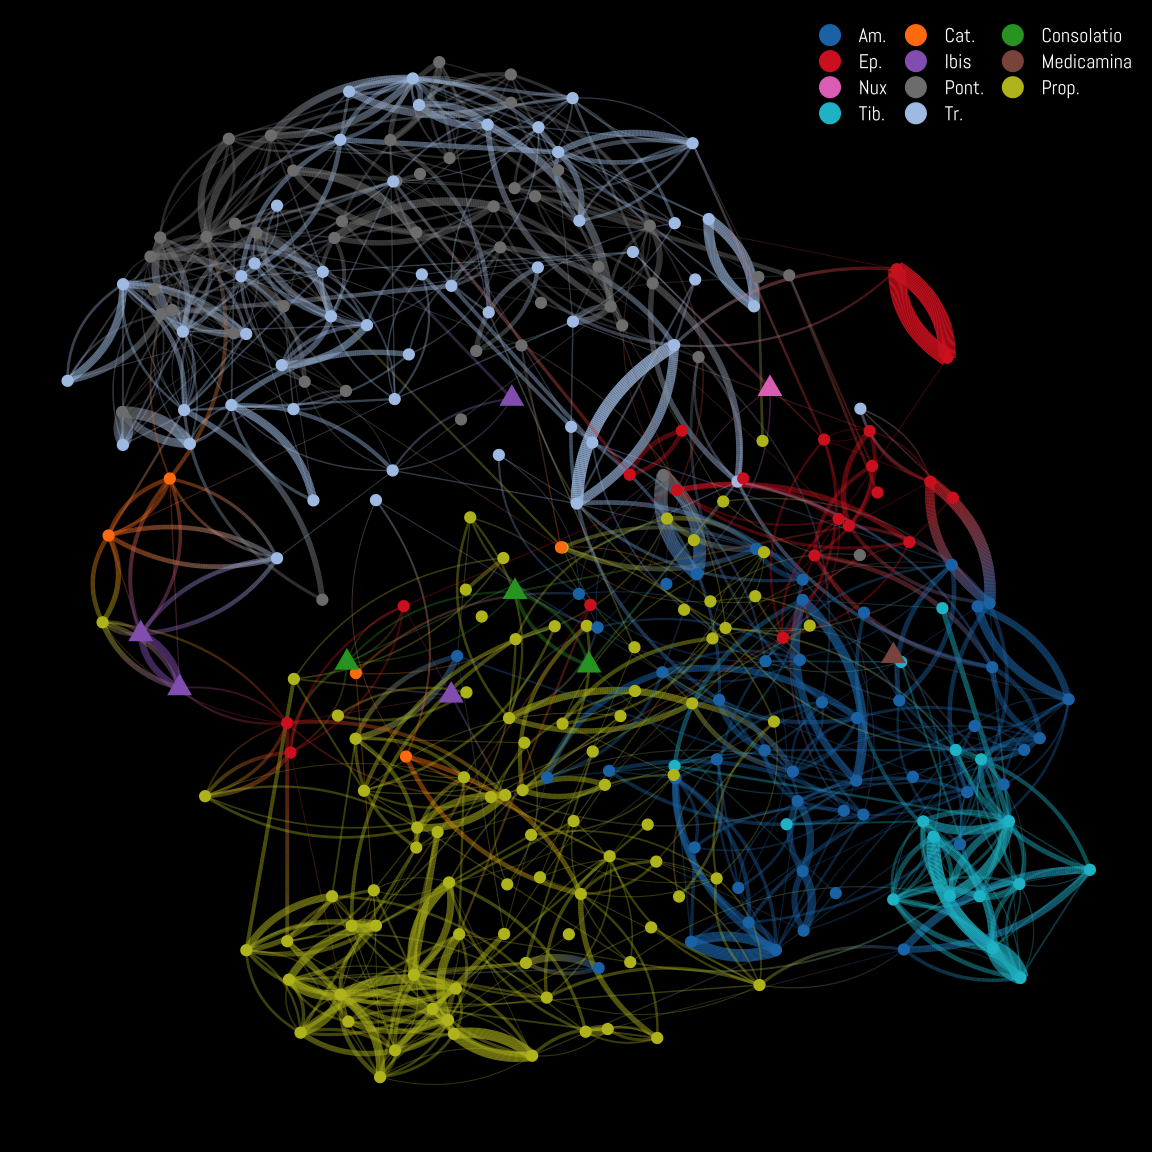

In [99]:
%%R -i graph_trim  -h 8 -w 8 -u in -r 144

# other libraries only need to be loaded once
library(dplyr)
library(ggraph)
library(tidygraph)
library(showtext)
library(ggsci)
library(stringr)
library(paletteer)
font_add_google("Abel", "fnt")
showtext_auto()

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "grey50", "#A65628")
bgcol <- 'black'

# Seed for the layout
set.seed(42)
gr1 <- as_tbl_graph(graph_trim)
# Plot
gr1 %>%
    # Add a node attribute called 'work' which is the poem name with
    # no numbers eg Pont. 3 4 -> Pont.
    activate(nodes) %>%
    mutate(work = str_replace_all(name, '\\s[0-9]+', '')) %>%
    # Layout with Fruchtermann Reingold
    ggraph(layout = 'fr') + 
    # fan2 does curved lines when nodes are linked in both directions
    # and also lets you interpolate colour along the edge
    geom_edge_fan2(
        aes(
            # Aesthetically filter out noisy minor edges.
            # This magic param is determined by experimentation
            # and depends on the number of samples etc.
            # Slightly hacky, but doesn't affect graph layout,
            # just makes the visualisation cleaner.
            filter=weight>=150,
            width=weight,
            color=node.work,
            alpha=weight
        ),
        strength=2,
        show.legend=FALSE
    ) +
    # Normal nodes
    geom_node_point(size = 2.2, aes(color = work), alpha=1) +
    # Special nodes
    geom_node_point(
        aes(
            filter=work %in% c('Nux','Ibis','Consolatio','Medicamina'),
            color=work
        ),
        size=4,
        shape=17,
        show.legend=FALSE
    ) +

    
    scale_fill_paletteer_d('ggsci::category20_d3') +
    scale_colour_paletteer_d('ggsci::category20_d3') +
    scale_edge_color_manual(values=pal_d3("category20")(20)) +
    scale_edge_width(range=c(0.2,4)) +
    scale_edge_alpha(range=c(0.3,1)) +
    
    guides(color=guide_legend(ncol=3,byrow=TRUE, override.aes = aes(size=4.5))) +

    theme_minimal() +
    theme(
        #plot.title = element_text(margin = margin(b = 50)),
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol,color=bgcol),
        legend.title=element_blank(),
        legend.position=c(0.85,0.94),
        #legend.position= 'None',
        legend.text=element_text(size=10,color='white'),
        legend.spacing.x = unit(2, 'mm'),
        legend.spacing.y = unit(-1.5, 'mm'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text = element_text(family="fnt"),
        panel.grid.minor=element_blank(), 
        panel.grid.major=element_blank()
    )

# fn <- "ele_ngrams_bct_black.pdf"
# ggsave(fn, dpi=600, width=8, height=6, device=cairo_pdf)
